<a href="https://colab.research.google.com/github/mickymarsh/OCR-Based-Invoice-and-Receipt-Data-Extractor/blob/main/finetuneLaoutLMv3%20for%20receipts/preprossaing_done.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- Step 1: Mount Google Drive (optional) ---
from google.colab import drive
drive.mount('/content/drive')  # Uncomment if dataset is in Google Drive

Mounted at /content/drive


In [ ]:
# --- Step 2: Install dependencies ---
!pip install pillow tqdm pytesseract easyocr numpy opencv-python
!apt-get install -y tesseract-ocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 30.1 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
import json
import os
from pathlib import Path
from PIL import Image
from tqdm import tqdm

import pytesseract
import easyocr

In [ ]:
# --- Step 3: Utility functions ---
def read_classes(dataset_root: Path):
    classes_file = dataset_root / 'classes.txt'
    if classes_file.exists():
        with classes_file.open('r', encoding='utf-8') as f:
            return [line.strip() for line in f if line.strip()]
    return None

In [ ]:
def yolo_to_pixels(yolo_line, img_w, img_h):
    parts = yolo_line.strip().split()
    cls = int(float(parts[0]))
    x_c, y_c, w, h = map(float, parts[1:5])
    x_min = (x_c - w/2) * img_w
    y_min = (y_c - h/2) * img_h
    x_max = (x_c + w/2) * img_w
    y_max = (y_c + h/2) * img_h
    return int(x_min), int(y_min), int(x_max), int(y_max), cls

In [ ]:
def pixels_to_1000(bbox, img_w, img_h):
    return [int(1000*bbox[0]/img_w), int(1000*bbox[1]/img_h), int(1000*bbox[2]/img_w), int(1000*bbox[3]/img_h)]

def run_ocr(image_path, engine='tesseract'):
    if engine == 'tesseract':
        img = Image.open(image_path).convert('RGB')
        data = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)
        words, boxes = [], []
        for i, text in enumerate(data['text']):
            if text.strip():
                words.append(text.strip())
                # Tesseract provides boxes as [left, top, width, height]
                boxes.append([data['left'][i], data['top'][i], data['left'][i]+data['width'][i], data['top'][i]+data['height'][i]])
        return words, boxes
    elif engine == 'easyocr':
        reader = easyocr.Reader(['en'], gpu=False)
        results = reader.readtext(str(image_path))
        words, boxes = [], []
        for bbox, text, conf in results:
            if text.strip():
                # EasyOCR provides boxes as [[x1, y1], [x2, y2], [x3, y3], [x4, y4]]
                # We'll convert it to [x_min, y_min, x_max, y_max]
                xs, ys = [p[0] for p in bbox], [p[1] for p in bbox]
                boxes.append([int(min(xs)), int(min(ys)), int(max(xs)), int(max(ys))])
                words.append(text.strip())
        return words, boxes
    else:
        return [], []

In [ ]:
def process_split(split_dir, classes, out_dir, use_ocr=True, ocr_engine='easyocr'):
    images_dir = split_dir / 'images'
    labels_dir = split_dir / 'labels'
    out_entries = []
    for img_path in tqdm(list(images_dir.glob('*'))):
        img = Image.open(img_path).convert('RGB')
        img_w, img_h = img.size
        label_file = labels_dir / (img_path.stem + '.txt')
        if not label_file.exists():
            continue
        yolo_boxes, yolo_cls = [], []
        for line in open(label_file, 'r', encoding='utf-8').read().strip().split('\n'):
            if line.strip():
                x_min, y_min, x_max, y_max, cls = yolo_to_pixels(line, img_w, img_h)
                yolo_boxes.append([x_min, y_min, x_max, y_max])
                yolo_cls.append(cls)

        token_words, token_boxes_pixels = [], []
        if use_ocr:
            token_words, token_boxes_pixels = run_ocr(img_path, engine=ocr_engine)
        else:
             # If not using OCR, you might want to extract words from the image based on YOLO boxes or skip token boxes
             # For simplicity, let's skip token boxes if not using OCR in this example
             pass

        region_boxes_1000 = [pixels_to_1000(b, img_w, img_h) for b in yolo_boxes]
        token_boxes_1000 = [pixels_to_1000(b, img_w, img_h) for b in token_boxes_pixels]

        region_labels = ['B-' + (classes[c] if classes else str(c)) for c in yolo_cls]

        out_entries.append({
            "id": img_path.stem,
            "image": str(img_path),
            "region_bboxes": region_boxes_1000,
            "region_labels": region_labels,
            "token_words": token_words,
            "token_bboxes": token_boxes_1000
        })

    out_file = out_dir / f"{split_dir.name}.jsonl"
    with open(out_file, 'w', encoding='utf-8') as f:
        for e in out_entries:
            f.write(json.dumps(e) + '\n')
    print(f"Wrote {len(out_entries)} entries to {out_file}")

In [ ]:
# --- Step 4: Run conversion ---
dataset_root = Path('/content/drive/MyDrive/recipt yolo dataset/Receipts.v5i.yolov8_1')  # Change to your dataset path
out_dir = Path('/content/drive/MyDrive/recipt-yolo-dataset/hf_dataset2')
out_dir.mkdir(parents=True, exist_ok=True)
classes =  ['Address', 'Date', 'Item', 'OrderId', 'Subtotal', 'Tax', 'Title', 'TotalPrice']


print(f"Dataset root exists: {dataset_root.exists()}")
print(f"Output directory exists: {out_dir.exists()}")

for split in ['train']:
    split_dir = dataset_root / split
    print(f"Checking split directory: {split_dir}")
    if split_dir.exists():
        print(f"Split directory {split} exists. Processing...")
        process_split(split_dir, classes, out_dir, use_ocr=True, ocr_engine='easyocr')
    else:
        print(f"Split directory {split} does not exist at {split_dir}. Skipping...")


print("Conversion complete.")

Dataset root exists: True
Output directory exists: True
Checking split directory: /content/drive/MyDrive/recipt yolo dataset/Receipts.v5i.yolov8_1/train
Split directory train exists. Processing...


  0%|          | 0/1227 [00:00<?, ?it/s]WARNING:easyocr.easyocr:Using CPU. Note: This module is much faster with a GPU.


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

100%|██████████| 1227/1227 [3:24:59<00:00, 10.02s/it]


Wrote 1227 entries to /content/drive/MyDrive/recipt-yolo-dataset/hf_dataset2/train.jsonl
Checking split directory: /content/drive/MyDrive/recipt yolo dataset/Receipts.v5i.yolov8_1/valid
Split directory valid exists. Processing...


  2%|▏         | 8/346 [01:27<1:01:20, 10.89s/it]


KeyboardInterrupt: 

/content/drive/MyDrive/recipt yolo dataset/Receipts.v5i.yolov8_1/train/images/receipt_image_528_jpg.rf.403d2ae83530aad12f4b6eff18aec8a8.jpg


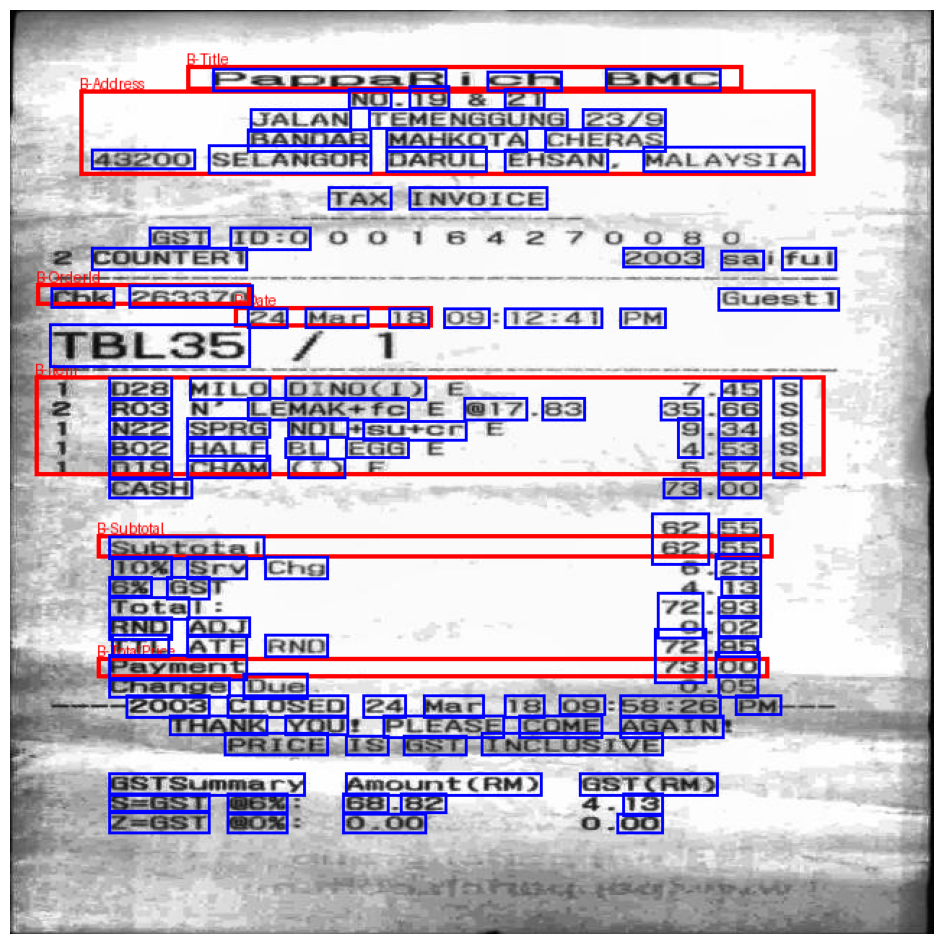

In [ ]:
import json
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from pathlib import Path # Import Path

# Paths
json_path = "/content/drive/MyDrive/recipt-yolo-dataset/hf_dataset2/train.jsonl"

# Load JSONL data
data = []
with open(json_path, "r", encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line))

# Pick an example (assuming the image path in the JSONL is relative to the dataset root)
# You might need to adjust the image_path here based on how the image paths are stored in your JSONL
example = data[10]  # change index if needed
img_relative_path = example["image"]
# Construct the full image path - assuming the relative path is from the dataset root
# You might need to adjust this based on your specific file structure
print(img_relative_path)
img_path = img_relative_path


img = Image.open(img_path).convert("RGB")
draw = ImageDraw.Draw(img)

# Draw region bboxes (Red)
for bbox, label in zip(example["region_bboxes"], example["region_labels"]):
    # Scale the bounding boxes from 1000 back to pixel coordinates
    x1, y1, x2, y2 = [int(b * img.size[0] / 1000) if i % 2 == 0 else int(b * img.size[1] / 1000) for i, b in enumerate(bbox)]
    draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
    draw.text((x1, y1 - 10), label, fill="red")

# Draw token bboxes (Blue)
if "token_bboxes" in example:
    for bbox, token in zip(example["token_bboxes"], example["token_words"]):
        # Scale the bounding boxes from 1000 back to pixel coordinates
        x1, y1, x2, y2 = [int(b * img.size[0] / 1000) if i % 2 == 0 else int(b * img.size[1] / 1000) for i, b in enumerate(bbox)]
        draw.rectangle([x1, y1, x2, y2], outline="blue", width=2)
        # Optionally draw token text
        # draw.text((x1, y1 - 10), token, fill="blue")


# Show result
plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
import json
import os # Import the os module


def is_center_inside(token_bbox, region_bbox):
    """Check if the token's center is inside the region bbox"""
    tx1, ty1, tx2, ty2 = token_bbox
    rx1, ry1, rx2, ry2 = region_bbox

    center_x = (tx1 + tx2) / 2
    center_y = (ty1 + ty2) / 2

    return (rx1 <= center_x <= rx2) and (ry1 <= center_y <= ry2)


# Load JSONL data
json_path = "/content/drive/MyDrive/recipt-yolo-dataset/hf_dataset2/train.jsonl"
data = []
with open(json_path, "r") as f:
    for line in f:
        data.append(json.loads(line))


# Process each image's annotations
for entry in data:
    token_labels = []
    if "token_bboxes" in entry and "region_bboxes" in entry: # Check if both exist
        for token_bbox in entry["token_bboxes"]:
            matched_label = "extra"  # Default label
            for region_bbox, region_name in zip(entry["region_bboxes"], entry["region_labels"]):
                # Scale region_bbox to match token_bbox scale (1000-based)
                # Note: Assuming token_bboxes are also 1000-based as per the process_split output
                if is_center_inside(token_bbox, region_bbox):
                    matched_label = region_name  # Assign region label if inside
                    break  # Stop checking regions once a match is found
            token_labels.append(matched_label)
    elif "token_bboxes" in entry: # If only token_bboxes exist, label all as 'extra'
         token_labels = ["extra"] * len(entry["token_bboxes"])
    # If no token_bboxes, token_labels remains empty

    entry["token_labels"] = token_labels


# Save updated JSON
output_path = "/content/drive/MyDrive/recipt-yolo-dataset/train2/annotations_with_token_labels.json"
# Create parent directories if they don't exist
output_dir = os.path.dirname(output_path)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Note: Saving as a single JSON file, not JSONL
with open(output_path, "w") as f:
    json.dump(data, f, indent=2)

print(f"Updated annotations saved to {output_path}")

Updated annotations saved to /content/drive/MyDrive/recipt-yolo-dataset/train2/annotations_with_token_labels.json


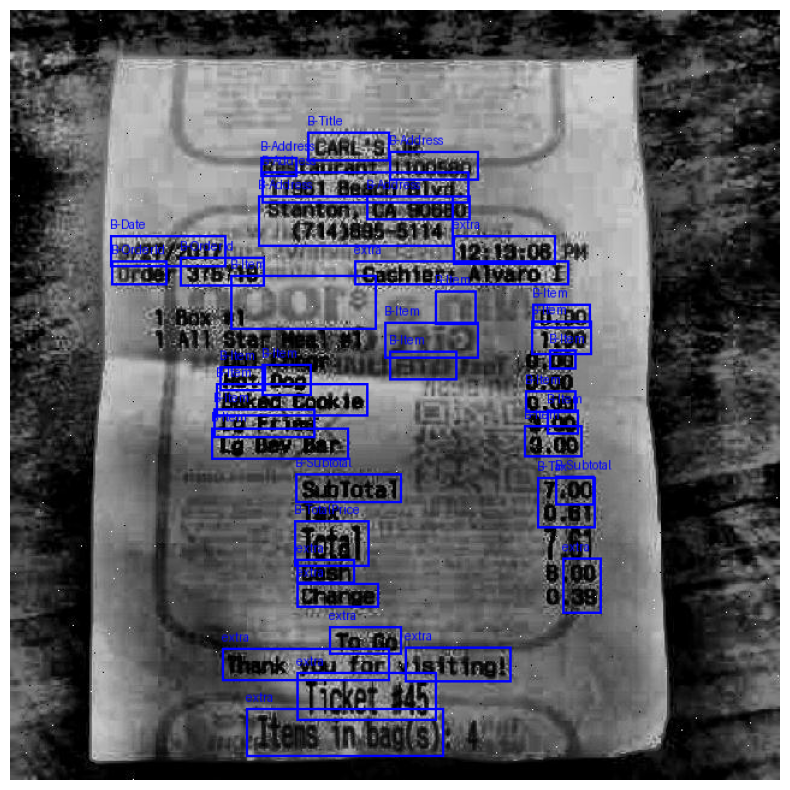

In [ ]:
import json
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from pathlib import Path



# Paths
annotations_path = "/content/drive/MyDrive/recipt-yolo-dataset/train2/annotations_with_token_labels.json"



# Load annotations
with open(annotations_path, "r", encoding='utf-8') as f:
    annotations_data = json.load(f)

# Pick example
example_jsonl = annotations_data[1201]  # change index as needed
img_relative_path = example_jsonl["image"]

dataset_root = Path('/content/drive/MyDrive/recipt yolo dataset/Receipts.v5i.yolov8_1')
img_path = dataset_root / Path(img_relative_path).relative_to(dataset_root)

# Load image
img = Image.open(img_path).convert("RGB")
draw = ImageDraw.Draw(img)

# Find matching annotation
example_annotation = next((entry for entry in annotations_data if entry["id"] == example_jsonl["id"]), None)

if example_annotation:
    try:
        font = ImageFont.truetype("arial.ttf", 16)
    except IOError:
        font = ImageFont.load_default()

    seen_boxes = set()

    for bbox_1000, label in zip(example_annotation["token_bboxes"], example_annotation["token_labels"]):
        # Remove this check to draw all token bounding boxes
        # if label.lower() == "extra":
        #     continue

        # Convert coordinates
        x1 = int(bbox_1000[0] * img.width / 1000)
        y1 = int(bbox_1000[1] * img.height / 1000)
        x2 = int(bbox_1000[2] * img.width / 1000)
        y2 = int(bbox_1000[3] * img.height / 1000)

        box_tuple = (x1, y1, x2, y2, label)
        if box_tuple in seen_boxes:
            continue
        seen_boxes.add(box_tuple)

        draw.rectangle([x1, y1, x2, y2], outline="blue", width=2)
        draw.text((x1, max(y1 - 15, 0)), label, fill="blue", font=font) # Optionally draw token label


    # Show image
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.show()
else:
    print(f"No annotations found for image ID: {example_jsonl['id']}")